<a href="https://colab.research.google.com/github/KarunphopSavanachai/First-Pairs-Trading-Analysis-for-study-/blob/main/First_Pairs_Trading_Analysis_(for_study).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install using libary.

In [6]:
pip install pandas yfinance statsmodels matplotlib numpy

1. Download the data.

In [7]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Data Fetching and Preparation (Corrected Column Selection) ---
# Define the list of tickers and the date range
tickers =  ['NFLX', 'DIS', 'AMZN', 'WBD', 'PARA']
start_date = '2023-05-01'
end_date = '2024-05-01'

# Create a list to hold the data for each ticker
all_data_list = []

print("--- Fetching Data ---")
# Loop through each ticker and download its data individually
for ticker in tickers:
    try:
        print(f"Fetching data for {ticker}...")
        # yfinance now returns adjusted prices in the 'Close' column by default
        data = yf.download(ticker, start=start_date, end=end_date)
        if not data.empty:
            # Select the 'Close' column (which is the adjusted close) and rename it
            all_data_list.append(data[['Close']].rename(columns={'Close': ticker}))
        else:
            print(f"Warning: No data was returned for {ticker}.")
    except Exception as e:
        print(f"An error occurred while fetching data for {ticker}: {e}")

# Combine all the individual dataframes into one single dataframe using a more robust merge
if all_data_list:
    # Start with the first DataFrame in the list
    all_data_df = all_data_list[0]
    # Iteratively merge the rest of the DataFrames
    for i in range(1, len(all_data_list)):
        all_data_df = pd.merge(all_data_df, all_data_list[i], on='Date', how='outer')

    # Sort by date and then fill any missing values forward, then backward
    all_data_df.sort_index(inplace=True)
    all_data_df.fillna(method='ffill', inplace=True)
    all_data_df.fillna(method='bfill', inplace=True)
    all_data_df.dropna(inplace=True) # Drop any remaining NaNs
else:
    # If the list is empty, create an empty DataFrame
    all_data_df = pd.DataFrame()

# Print the resulting DataFrame and its shape
print("\n--- Combined Stock Data ---")
print(all_data_df.head())
print("\n--- Data Frame Shape ---")
print(f"Shape: {all_data_df.shape}")




/tmp/ipython-input-1065177390.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1065177390.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1065177390.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1065177390.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1

--- Fetching Data ---
Fetching data for NFLX...
Fetching data for DIS...
Fetching data for AMZN...
Fetching data for WBD...
Fetching data for PARA...

--- Combined Stock Data ---
Price             NFLX         DIS        AMZN    WBD       PARA
Ticker            NFLX         DIS        AMZN    WBD       PARA
Date                                                            
2023-05-01  324.119995  100.534027  102.050003  13.29  22.591501
2023-05-02  317.549988   98.950432  103.629997  12.69  22.157785
2023-05-03  319.299988   99.206154  103.650002  12.83  22.061409
2023-05-04  320.779999   95.852074  104.000000  12.33  15.806337
2023-05-05  322.760010   98.871727  105.660004  12.89  16.249689

--- Data Frame Shape ---
Shape: (252, 5)



/tmp/ipython-input-1065177390.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data_df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-1065177390.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data_df.fillna(method='bfill', inplace=True)


    2. Finds all pairs of cointegrated stocks from a dataframe of price series(IF  p value < 0.05 then the stock is cointegrated).

    3. Find the best pair (the best pair is the pair that has the least p value).

    4. Moving Average Analysis using 5-day and 20-day moving averages of the spread.

    5. Z-Score Calculation and Plotting Calculate the standard deviation of the 20-day moving average ( z_score_20_5 = (spread_ma5 - spread_ma20) / spread_std20).

    6. Trading Signals A "buy" signal when z > -1 and an "exit" when z < 1 means (using z_score_20_5).

    7. Profit and loss Calculation.



--- Cointegrated Pairs (p-value < 0.05) ---
Pair: ('WBD', 'WBD')-('PARA', 'PARA'), P-value: 0.0050
Pair: ('NFLX', 'NFLX')-('DIS', 'DIS'), P-value: 0.0062
Pair: ('DIS', 'DIS')-('AMZN', 'AMZN'), P-value: 0.0187

--- Choosing best pair with least p-value: ('WBD', 'WBD')-('PARA', 'PARA') ---


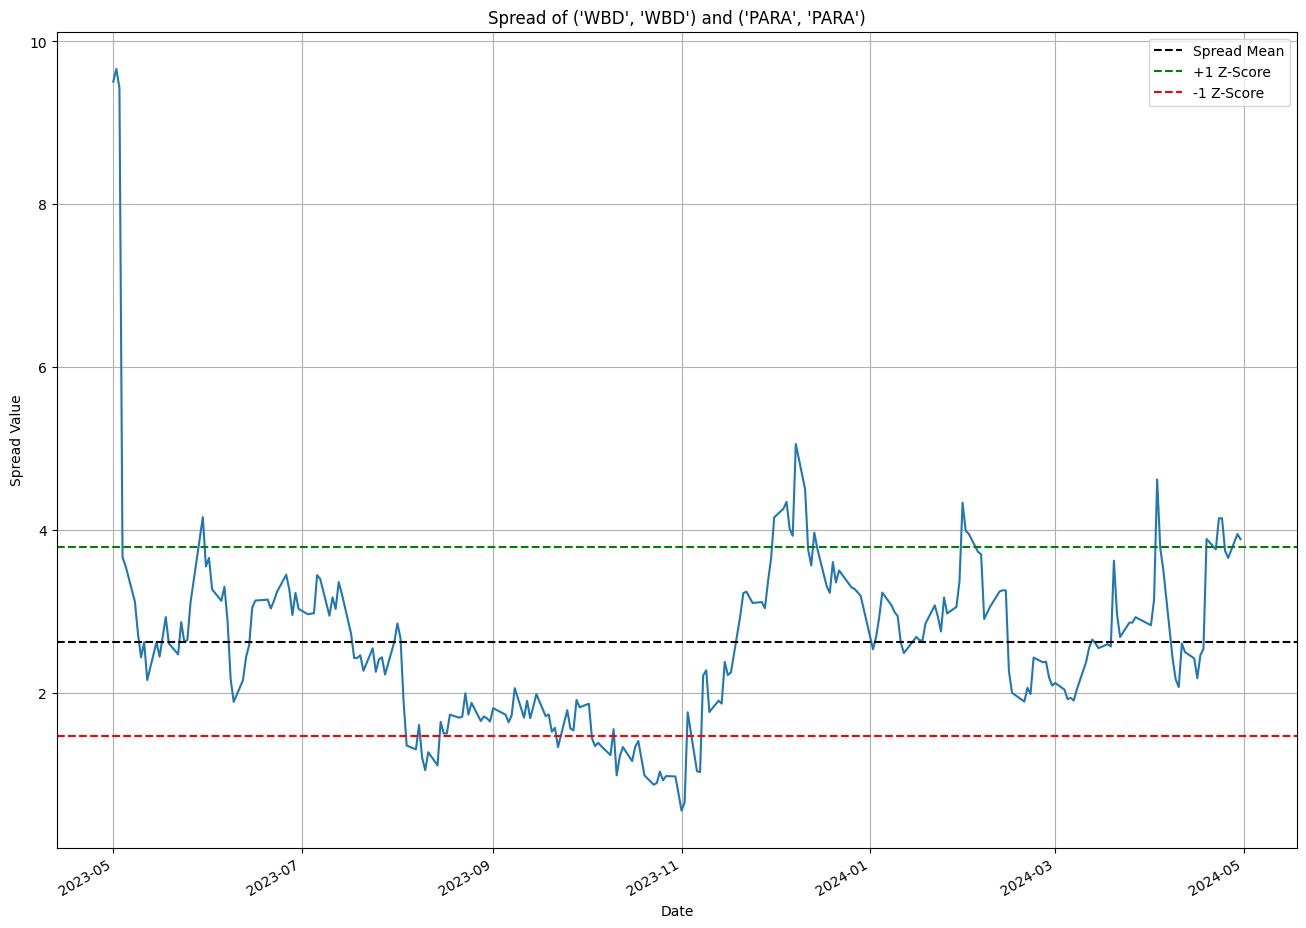

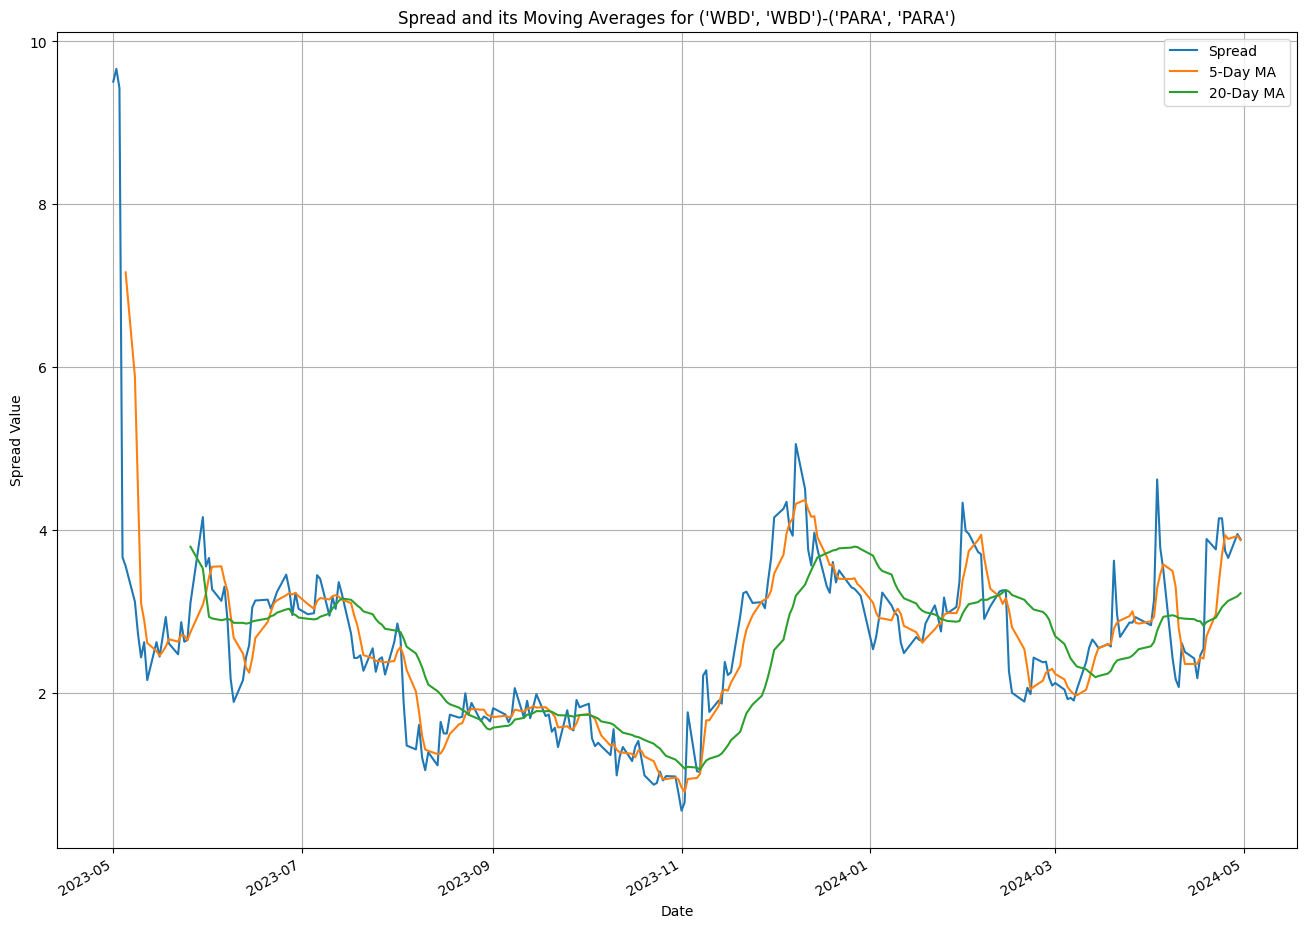

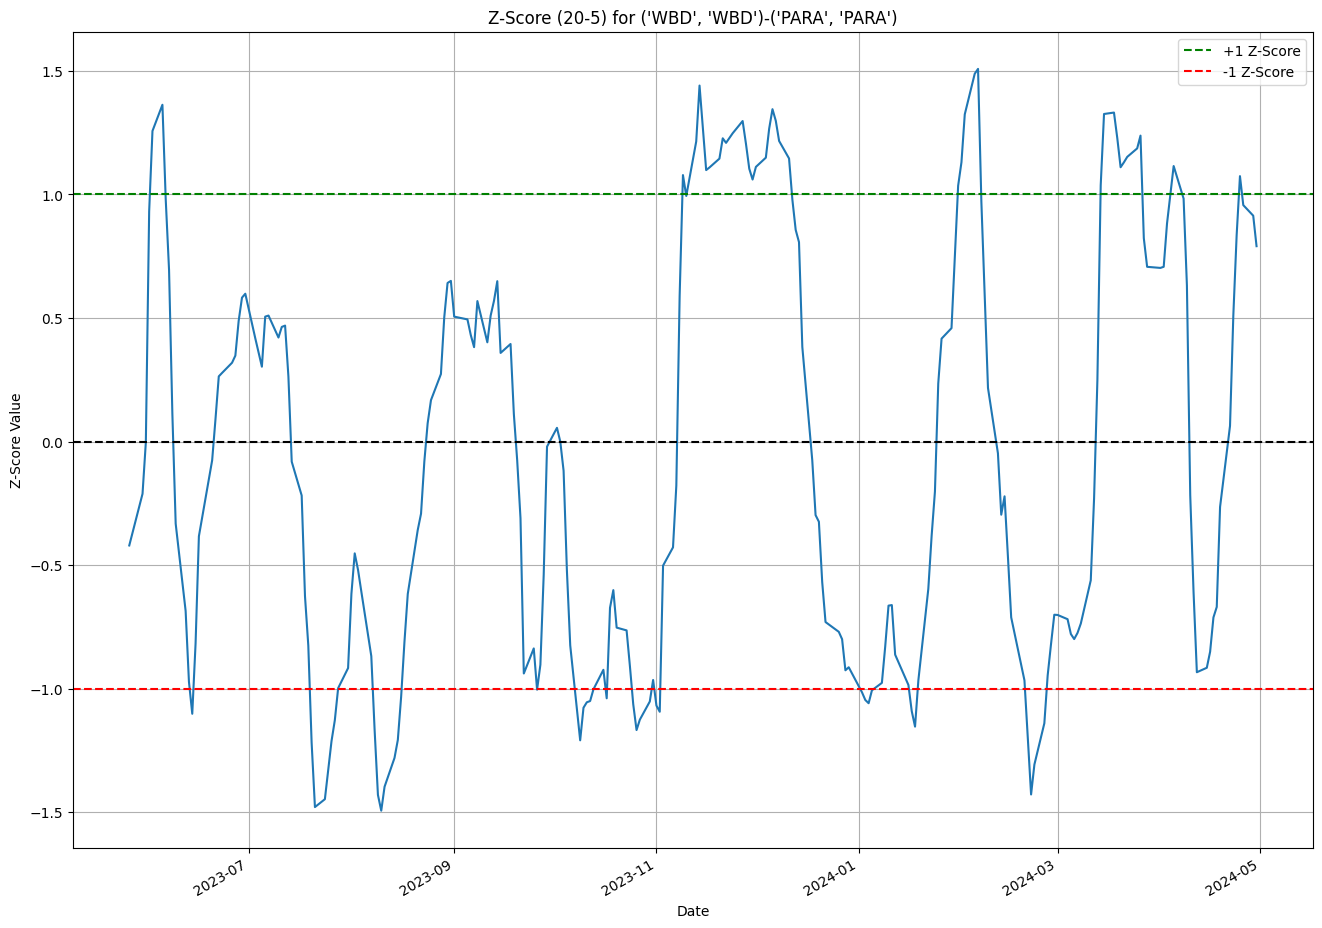

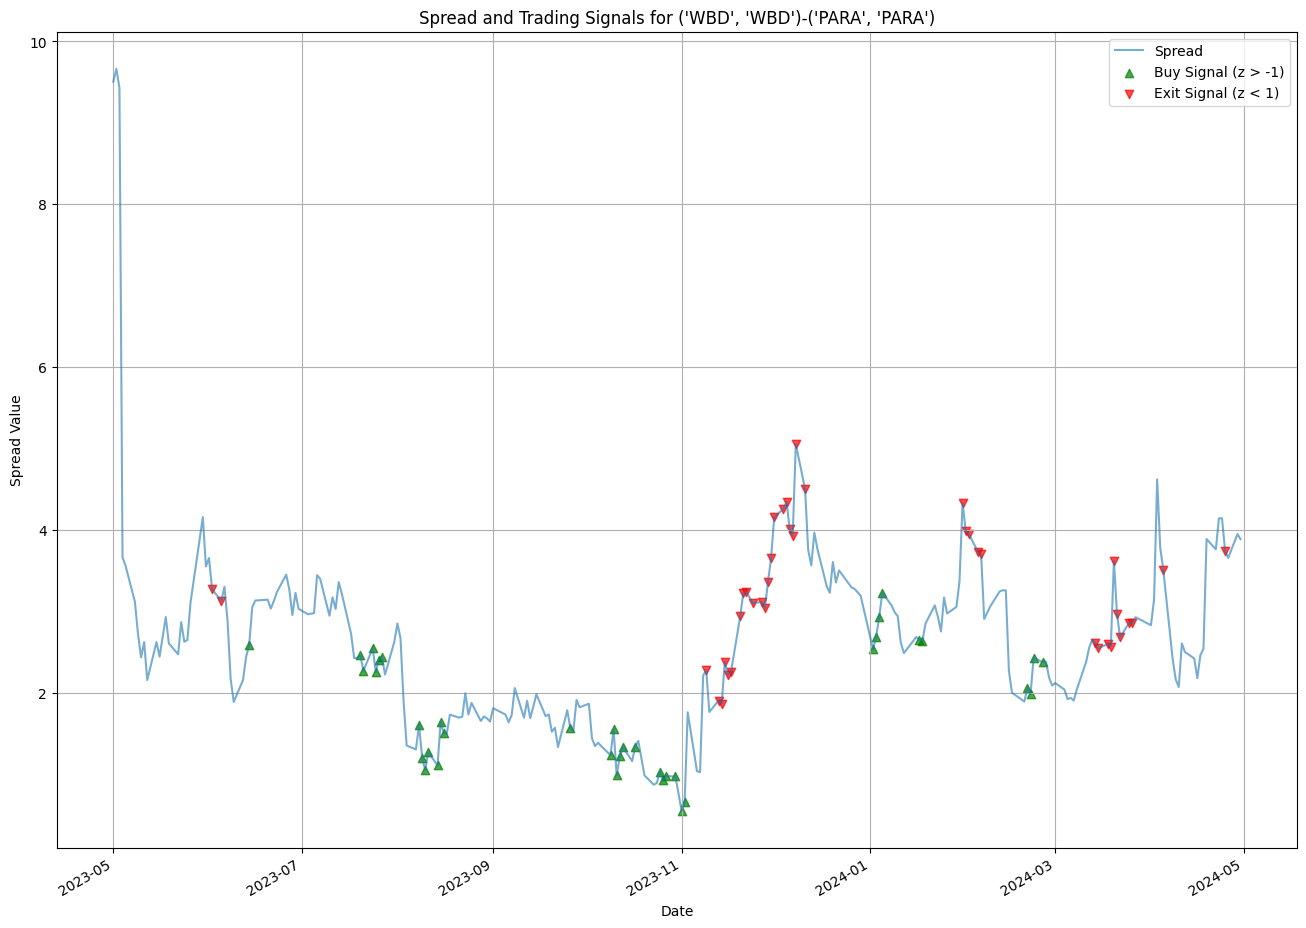


--- Total PnL from Strategy (USD, 100 shares) ---
$300.87


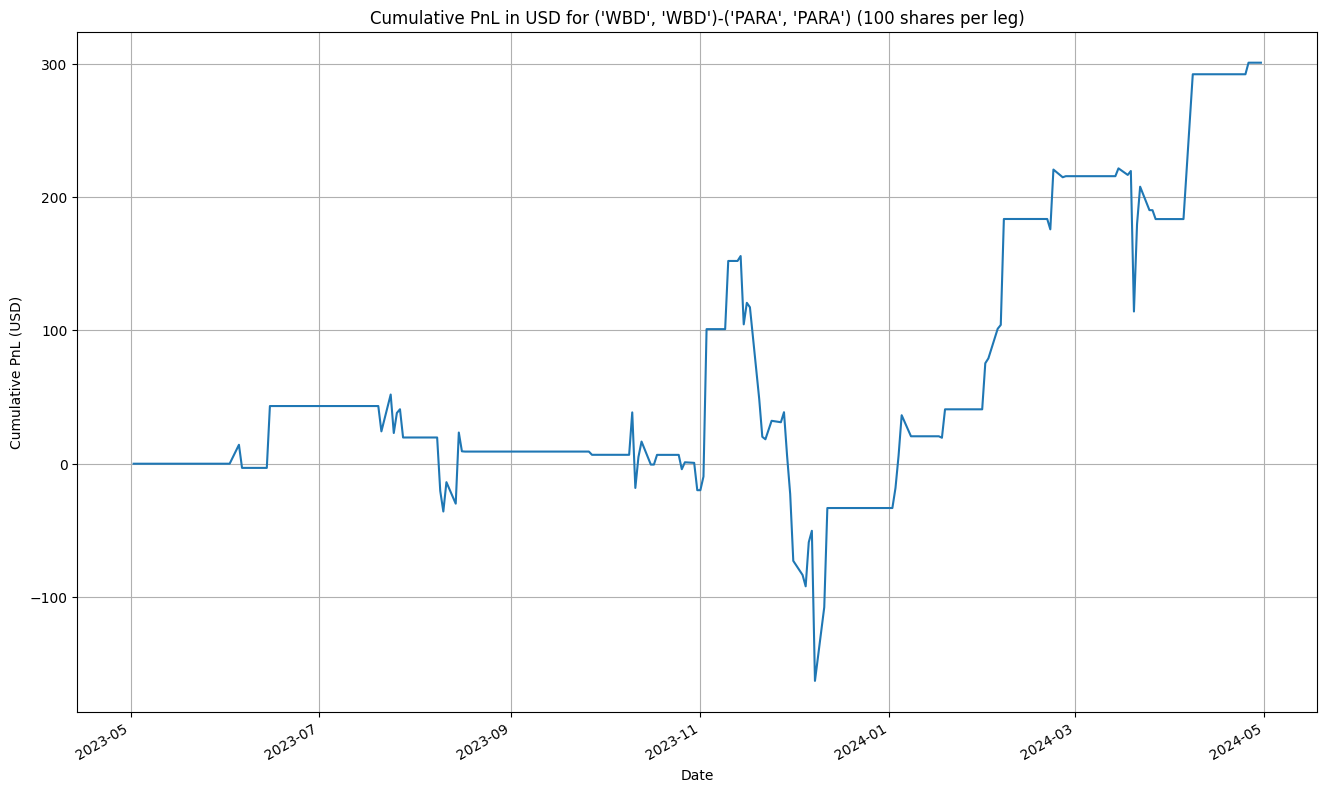

In [8]:
# --- 2. Find Cointegrated Pairs ---
def find_cointegrated_pairs(data):
    """
    Finds all pairs of cointegrated stocks from a dataframe of price series.
    Uses the Engle-Granger two-step method.
    """
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i + 1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            # Test for cointegration
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            # If p-value is less than 0.05, the pair is cointegrated
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j], pvalue))
    return score_matrix, pvalue_matrix, pairs

# Find the cointegrated pairs from the fetched data
if not all_data_df.empty:
    scores, pvalues, cointegrated_pairs = find_cointegrated_pairs(all_data_df)

    # Sort pairs by p-value to find the best one
    cointegrated_pairs.sort(key=lambda x: x[2])

    print("\n--- Cointegrated Pairs (p-value < 0.05) ---")
    if not cointegrated_pairs:
        print("No cointegrated pairs found with a p-value less than 0.05.")
    else:
        for pair in cointegrated_pairs:
            print(f"Pair: {pair[0]}-{pair[1]}, P-value: {pair[2]:.4f}")

        # --- 3. Choose Best Pair and Analyze Spread ---
        best_pair = cointegrated_pairs[0]
        stock1_ticker = best_pair[0]
        stock2_ticker = best_pair[1]
        print(f"\n--- Choosing best pair with least p-value: {stock1_ticker}-{stock2_ticker} ---")

        stock1 = all_data_df[stock1_ticker]
        stock2 = all_data_df[stock2_ticker]

        # Calculate the spread using a linear regression (OLS) to find the hedge ratio
        stock1_with_const = sm.add_constant(stock1)
        model = sm.OLS(stock2, stock1_with_const).fit()
        hedge_ratio = model.params.iloc[1] # Use iloc for position-based access
        spread = stock2 - hedge_ratio * stock1

        # --- Plot 1: Spread with Mean and Z-Score Bands ---
        plt.figure(figsize=(16,12))
        spread.plot()
        plt.axhline(spread.mean(), color='black', linestyle='--', label='Spread Mean')
        # Plot +1 and -1 standard deviation (z-score) lines
        plt.axhline(spread.mean() + spread.std(), color='green', linestyle='--', label='+1 Z-Score')
        plt.axhline(spread.mean() - spread.std(), color='red', linestyle='--', label='-1 Z-Score')
        plt.title(f'Spread of {stock1_ticker} and {stock2_ticker}')
        plt.xlabel('Date')
        plt.ylabel('Spread Value')
        plt.legend()
        plt.grid(True)
        plt.show()

        # --- 4. Moving Average Analysis ---
        # Calculate 5-day and 20-day moving averages of the spread
        spread_ma5 = spread.rolling(window=5).mean()
        spread_ma20 = spread.rolling(window=20).mean()

        # --- Plot 2: Spread with Moving Averages ---
        plt.figure(figsize=(16,12))
        spread.plot(label='Spread')
        spread_ma5.plot(label='5-Day MA')
        spread_ma20.plot(label='20-Day MA')
        plt.title(f'Spread and its Moving Averages for {stock1_ticker}-{stock2_ticker}')
        plt.xlabel('Date')
        plt.ylabel('Spread Value')
        plt.legend()
        plt.grid(True)
        plt.show()

        # --- 5. Z-Score Calculation and Plotting ---
        # Calculate the standard deviation of the 20-day moving average
        spread_std20 = spread.rolling(window=20).std()
        # Calculate the z-score as defined
        z_score_20_5 = (spread_ma5 - spread_ma20) / spread_std20

        # --- Plot 3: Z-Score Plot ---
        plt.figure(figsize=(16,12))
        z_score_20_5.plot()
        plt.axhline(0, color='black', linestyle='--')
        plt.axhline(1.0, color='green', linestyle='--', label='+1 Z-Score')
        plt.axhline(-1.0, color='red', linestyle='--', label='-1 Z-Score')
        plt.title(f'Z-Score (20-5) for {stock1_ticker}-{stock2_ticker}')
        plt.xlabel('Date')
        plt.ylabel('Z-Score Value')
        plt.legend()
        plt.grid(True)
        plt.show()

        # --- 6. Trading Signals ---
        # NOTE: The provided trading logic is unconventional.
        # A "buy" signal when z > -1 and an "exit" when z < 1 means
        # a position would be open almost constantly.
        # This implementation follows the prompt's instructions exactly.

        # Create a new DataFrame for signals
        signals_df = pd.DataFrame(index=all_data_df.index)
        signals_df['spread'] = spread
        signals_df['z_score'] = z_score_20_5

        # Generate buy signals: When z_score > -1
        signals_df['buy_signal'] = np.where(signals_df['z_score'] < -1, signals_df['spread'], np.nan)

        # Generate sell signals (exit): When z_score < 1
        signals_df['sell_signal'] = np.where(signals_df['z_score'] > 1, signals_df['spread'], np.nan)

        # --- Plot 4: Spread with Buy and Sell Signals ---
        plt.figure(figsize=(16,12))
        signals_df['spread'].plot(alpha=0.6, label='Spread')
        plt.scatter(signals_df.index, signals_df['buy_signal'], color='green', marker='^', label='Buy Signal (z > -1)', alpha=0.7)
        # Note: Plotting the exit signal with the same marker but different color as requested
        plt.scatter(signals_df.index, signals_df['sell_signal'], color='red', marker='v', label='Exit Signal (z < 1)', alpha=0.7)
        plt.title(f'Spread and Trading Signals for {stock1_ticker}-{stock2_ticker}')
        plt.xlabel('Date')
        plt.ylabel('Spread Value')
        plt.legend()
        plt.grid(True)
        plt.show()

        # --- 7. PnL Calculation in USD ---

        position_size = 100  # Number of stock2 shares per trade
        signals_df['position'] = 0
        signals_df.loc[signals_df['z_score'] < -1, 'position'] = 1   # Long spread
        signals_df.loc[signals_df['z_score'] > 1, 'position'] = -1  # Short spread



        # Calculate daily spread returns
        signals_df['spread_ret'] = signals_df['spread'].diff()

        # PnL in USD = position × change in spread × position_size
        signals_df['pnl_usd'] = signals_df['position'].shift(1) * signals_df['spread_ret'] * position_size

        # Cumulative PnL in USD
        signals_df['cum_pnl_usd'] = signals_df['pnl_usd'].cumsum()

        # Print total PnL
        total_pnl_usd = signals_df['pnl_usd'].sum()
        print(f"\n--- Total PnL from Strategy (USD, {position_size} shares) ---\n${total_pnl_usd:,.2f}")

        # --- Plot 5: Cumulative PnL in USD ---
        plt.figure(figsize=(16, 10))
        signals_df['cum_pnl_usd'].plot()
        plt.title(f'Cumulative PnL in USD for {stock1_ticker}-{stock2_ticker} ({position_size} shares per leg)')
        plt.xlabel('Date')
        plt.ylabel('Cumulative PnL (USD)')
        plt.grid(True)
        plt.show()
else:
    print("\nCould not proceed with analysis because the initial data is empty.")